# Práctica 4: Entrenamiento de redes neuronales
---
### Autores:
Raúl Murillo Montero - 5º Doble Grado en Ingeniería Informática - Matemáticas   
Miguel Sierra Esteso - 4º Grado en Ingeniería Informática

---
**Fecha de entrega:** 22 de noviembre de 2018, 18.00h

In [183]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt
import displayData as disp
import checkNNGradients as checkNNG
from sklearn.preprocessing import OneHotEncoder

## 1. Función de coste
El objetivo de esta primera parte de la práctica es implementar el cálculo de la función de coste
de una red neuronal para un conjunto de ejemplos de entrenamiento.
Se utiliza el mismo conjunto de datos de la práctica 3. El fichero `ex4data1.mat` contiene 5000 ejemplos de entrenamiento
en el formato nativo para matrices de Octave/Matlab.

In [2]:
weights = loadmat('ex4data1.mat')
# se pueden consultar las claves con data.keys()
y = weights['y']
X = weights ['X']
# almacena los datos leídos en X, y

<IPython.core.display.Javascript object>


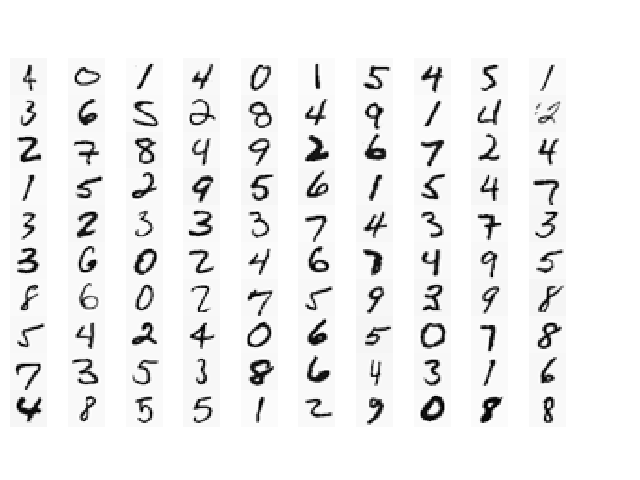

In [3]:
# Selecciona aleatoriamente 100 ejemplos y los pinta
sample = np.random.choice(X.shape[0], 100)
disp.displayData(X[sample])
plt.show()

El fichero `ex4weights.mat` contiene las matrices $\Theta^{(1)}$ y $\Theta^{(2)}$ con el resultado de haber
entrenado la red neuronal y que podemos cargar con la función `scipy.io.loadmat`

In [4]:
weights = loadmat('ex4weights.mat')
theta1,  theta2 = weights ['Theta1'], weights['Theta2']
# Theta1 es de dimensión 25 x 401
# Theta2 es de dimensión 10 x 26

Funciones auxiliares: *sigmoide* y *fordward propagation*.

In [5]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

In [236]:
def forwardprop(theta1, theta2, X):
    m = X.shape[0]
    # Input layer: a1 = X, add a1_0
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    # Hidden layer
    z2 = a1.dot(theta1.T)
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1) # Add a2_0
    # Output layer
    z3 = a2.dot(theta2.T)
    a3 = sigmoid(z3) # hypothesis
    return a1, z2, a2, z3, a3

Función de coste

In [237]:
def coste(theta1, theta2, X, y):
    m = X.shape[0]
    h = forwardprop(theta1, theta2, X)[4]
    J = (np.multiply(-y, np.log(h)) - np.multiply((1 - y), np.log(1 - h))).sum() / m
    return J

In [238]:
# Esta primera versión de la función de coste debería devolver un valor aproximado de 0.287629.
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)
coste(theta1, theta2, X, y_onehot)

0.2876291651613189

In [64]:
def coste_reg(theta1, theta2, X, y, l):
    m = X.shape[0]
    J = coste(theta1, theta2, X, y)
    J += (l / (2 * m)) * (np.sum(np.power(theta1[:, 1:], 2)) + np.sum(np.power(theta2[:, 1:], 2)))
    return J

In [65]:
# Con los valores proporcionados para theta1 y theta2, el coste regularizado debería estar en torno a 0.383770.
l = 1
coste_reg(theta1, theta2, X, y_onehot, l)

0.38376985909092365

## 2. Cálculo del gradiente

En esta parte de la práctica has de implementar el algoritmo de retro-propagación para añadir
el cálculo del gradiente a la función `backprop` que ha de devolverlo junto con el coste.

In [144]:
def der_sigmoid(x):
    return np.multiply(sigmoid(x),(1 - sigmoid(x)))

In [67]:
def pesosAleatorios(L_in, L_out):
    eps = 0.12  # it can be assigned by a formula
    # dimension of the matrix is (L_out, 1 + L_in)
    return np.random.uniform(low=-eps, high=eps, size=(L_out, 1 + L_in))    

### 2.1. Retro-propagación

In [180]:
# Cálculo del gradiente
m = len(X)
# 1
a1, z2, a2, a3 = forwardprop(theta1, theta2, X)
# 2
d3 = a3 - y_onehot
# 3
# Hay que quitar la columna de 1s a theta2
d2 = np.multiply(d3.dot(theta2[:,1:]),der_sigmoid(z2))
# 4
delta1 = np.zeros(theta1.shape)
delta2 = np.zeros(theta2.shape)
delta1 += d2.T.dot(a1)
delta2 += d3.T.dot(a2)
# 5
delta1 = delta1 / m
delta2 = delta2 / m
# unravel the gradient matrices into a single array
grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))

(5000, 25)
(5000, 10)
(10, 26)
(26, 10)


In [182]:
delta1.shape, delta2.shape, theta1.shape, theta2.shape

((25, 401), (10, 26), (25, 401), (10, 26))

### 2.2 Chequeo del gradiente

In [239]:
def costNN(params_rn , num_entradas , num_ocultas , num_etiquetas , X, y , reg = True):
    m = X.shape[0]
    
    theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)],
                        (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):],
                        (num_etiquetas, (num_ocultas + 1)))
    
    if reg:
        return coste_reg(theta1, theta2, X, y, l)
    else:
        return coste(theta1, theta2, X, y)

In [ ]:
def backprop(params_rn , num_entradas , num_ocultas , num_etiquetas , X, y , reg = True):
    """
    backprop devuelve el coste y el gradiente de una red neuronal de dos capas
    """
    m = X.shape[0]
    
    # reshape the parameter array
    theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)],
                        (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):],
                        (num_etiquetas, (num_ocultas + 1)))
    
    # Cálculo del coste
    J = costNN(params_rn , num_entradas , num_ocultas , num_etiquetas , X, y , reg)

    # Cálculo del gradiente
    # 1
    a1, z2, a2, z3, h = forwardprop(theta1, theta2, X)
    # 2
    d3 = h - y_onehot
    # 3
    # Hay que quitar la columna de 1s a theta2
    d2 = np.multiply(d3.dot(theta2[:,1:]),der_sigmoid(z2))
    # 4
    delta1 = np.zeros(theta1.shape)
    delta2 = np.zeros(theta2.shape)
    delta1 += d2.T.dot(a1)
    delta2 += d3.T.dot(a2)
    # 5
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # 2.3. Redes neuronales regularizadas
    if reg_param:
        delta1[:, 1:] += reg_param / m * theta1[:, 1:]
        delta2[:, 1:] += reg_param / m * theta2[:, 1:]
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    return J, grad

## 3. Aprendizaje de los parámetros

In [235]:
opt.optimize()